# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Load the Data

In [2]:
# Load the data
df = pd.read_csv("cleaned_coursera_dataset.csv")

In [3]:
df.head(0)

,Course Title,Rating,Provider,Level,Reviews,Type,Duration / Weeks


In [4]:
df.drop('Course Title', axis=1, inplace=True)

In [5]:
df.rename(columns={'Duration / Weeks': 'duration_weeks', 'Type': 'course_type'}, inplace=True)

In [6]:
df.rename(columns={'type': 'course_type'}, inplace=True)

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df

,rating,provider,level,reviews,course_type,duration_weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [9]:
df.dtypes

rating            float64
provider           object
level              object
reviews           float64
course_type        object
duration_weeks     object
dtype: object

In [10]:
# Extracting the duration in weeks
# Assuming that the duration is given as a range "min - max", we'll take the average of the range
def extract_weeks(duration):
    try:
        weeks = duration.split(" - ")
        if len(weeks) == 2:
            return (int(weeks[0]) + int(weeks[1])) / 2
        else:
            return int(weeks[0])
    except:
        return None

df['duration_weeks'] = df['duration_weeks'].apply(extract_weeks)

df.head()

,rating,provider,level,reviews,course_type,duration_weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,18.0
1,4.8,Google,Beginner,35000.0,Professional Certificate,18.0
2,4.8,Google,Beginner,112000.0,Professional Certificate,18.0
3,4.8,Google,Beginner,30000.0,Professional Certificate,18.0
4,4.8,Google,Beginner,83000.0,Professional Certificate,18.0


# Feature Selection

In [11]:
numerical_features = df.select_dtypes(include=['number']).columns

In [42]:
selected_columns = [
    'rating', 
    'reviews', 
    'duration_weeks']
data_clean = df[selected_columns]
data_clean

,rating,reviews,duration_weeks
0,4.8,151000.0,18.0
1,4.8,35000.0,18.0
2,4.8,112000.0,18.0
3,4.8,30000.0,18.0
4,4.8,83000.0,18.0
...,...,...,...
4299,3.9,32.0,2.5
4300,4.8,88.0,2.5
4301,4.4,62.0,2.5
4302,3.5,6.0,2.5


In [13]:
data_clean.shape

(4304, 3)

# Preprocessing the Data

In [14]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['provider', 'level', 'course_type'], dtype='object')

##  Encoding

In [15]:
# creating the train data, a copy of the original
df_train = data_clean.copy()

In [16]:
df_train.dtypes

rating            float64
reviews           float64
duration_weeks    float64
dtype: object

In [17]:
# Saving the categorical features in a list
categorical_features = df_train.select_dtypes(include=['object']).columns

In [18]:
categorical_features

Index([], dtype='object')

In [19]:
scaler = MinMaxScaler()
scaler.fit(df_train)
df_scaled = scaler.transform(df_train)

# Building and Training the model

In [20]:
wcss = []
for i in range(2, 20):  
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

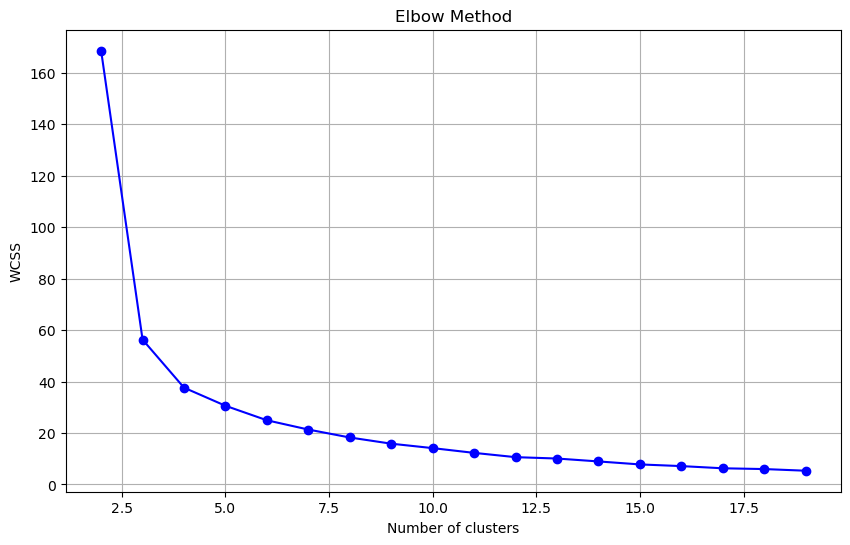

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [22]:
# Building the KMeans Model
optimal_clusters = 3

# Initialize and train the KMeans model
best_kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)


In [23]:
# predict
x_kmeans = best_kmeans.fit_predict(df_scaled)

# evaluate model

In [24]:
# Calculate the silhouette score, closer to 1 is better
silhouette_avg = silhouette_score(df_scaled, best_kmeans.labels_)

# Davies-Bouldin Index to evaluate clustering quality.
# Lower values indicate better separation between the clusters.
db_index = davies_bouldin_score(df_scaled, best_kmeans.labels_)

print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)


Silhouette Score: 0.7520316366501715
Davies-Bouldin Index: 0.35567862794312005


In [25]:
inertia = best_kmeans.inertia_
print("Inertia:", inertia)


Inertia: 56.28309249145437


In [26]:
df_train.columns

Index(['rating', 'reviews', 'duration_weeks'], dtype='object')

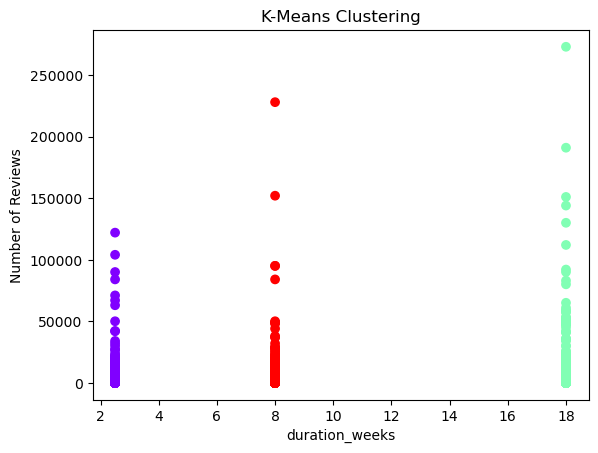

In [44]:
plt.scatter(df_train['duration_weeks'], 
            df_train['reviews'], 
            c=best_kmeans.labels_, 
            cmap='rainbow')

plt.title('K-Means Clustering')
plt.xlabel('duration_weeks')
plt.ylabel('Number of Reviews')
plt.show()


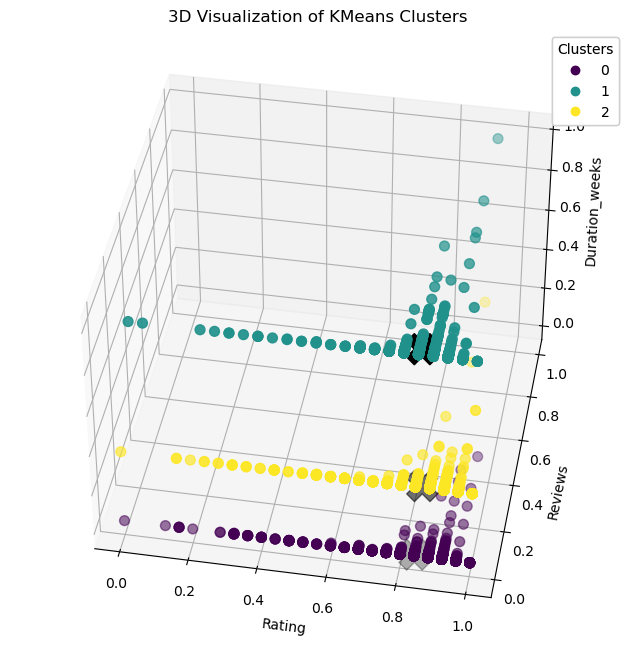

In [28]:


# Predicting the clusters
labels = best_kmeans.labels_

# Getting the cluster centers
centroids = best_kmeans.cluster_centers_

# Creating a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the data points
scatter = ax.scatter(df_scaled[:, 0], df_scaled[:, 1], df_scaled[:, 2], c=labels, cmap='viridis', s=50)

# Scatter plot for the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='black', s=500, marker='X')

# Adding labels and title
ax.set_title('3D Visualization of KMeans Clusters')
ax.set_xlabel('Rating')
ax.set_ylabel('Reviews')
ax.set_zlabel('Duration_weeks')

# Adding a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
# plt.tight_layout()
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.view_init(elev=40, azim=-80)  # Adjust these values to rotate


plt.show()


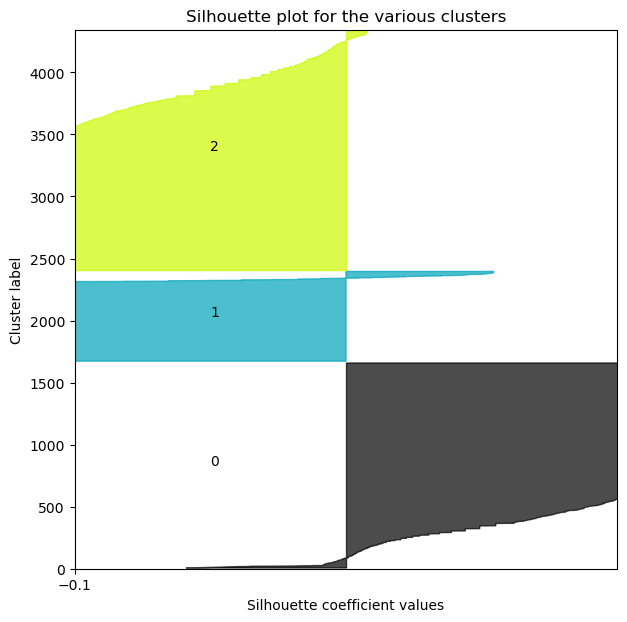

In [29]:
from sklearn.metrics import silhouette_samples, silhouette_score

sample_silhouette_values = silhouette_samples(df_train, best_kmeans.labels_)

y_lower = 10
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(7, 7)

ax1.set_xlim([-0.1, 0.1])
ax1.set_ylim([0, len(df_train) + (optimal_clusters + 1) * 10])

for i in range(optimal_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[best_kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / optimal_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title("Silhouette plot for the various clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
# ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks(np.arange(-0.1,  0.2))

plt.show()

# Predictions

In [30]:
df_train.columns

Index(['rating', 'reviews', 'duration_weeks'], dtype='object')

In [31]:
rating = 5
reviews = 40000
duration = 1

new_data = [[rating, reviews, duration]]
predictions = best_kmeans.predict(new_data)
print("Predicted clusters for new data:", predictions)


Predicted clusters for new data: [1]


# Clusters Distribution

In [32]:
df_train['Cluster'] = best_kmeans.labels_

In [33]:
cluster_0 = df[df_train['Cluster'] == 0]
cluster_1 = df[df_train['Cluster'] == 1]
cluster_2 = df[df_train['Cluster'] == 2]

In [34]:
cluster_0.shape

(1653, 6)

In [35]:
cluster_1.shape

(724, 6)

In [36]:
cluster_2.shape

(1927, 6)

In [37]:
cluster_0['reviews'].mean()

1534.6388384754991

In [39]:
cluster_1['reviews'].mean()

6588.013812154696

In [38]:
cluster_2['reviews'].mean()

1791.813700051894

- Cluster 0 = low
- Cluster 2 = medium
- Cluster 1 = high

In [40]:
import joblib
joblib.dump(best_kmeans, 'kmens_model.joblib')
joblib.dump(scaler, 'kmens_scaler.joblib')

['kmens_scaler.joblib']